# Modelo Predictivo Mejorado para Precios de Airbnb

Este notebook presenta una versión mejorada del modelo predictivo para estimar el precio por noche de propiedades en Airbnb. Incorporamos nuevas métricas de evaluación (EVS y MAPE), técnicas de ingeniería de características y algoritmos de modelado avanzados (XGBoost, LightGBM) para buscar una mayor precisión y una comprensión más profunda de los factores que influyen en el precio.

## 1. Importación de Bibliotecas

In [1]:
# Importación de bibliotecas estándar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y Modelado
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

# Métricas de Evaluación
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# Función para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Evitar división por cero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Configuración para visualizaciones
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
sns.set_palette("viridis")

# Para ignorar advertencias
import warnings
warnings.filterwarnings("ignore")

## 2. Carga y Exploración Inicial de Datos

In [2]:
# Cargar el dataset
df = pd.read_csv("transform_listings.csv")

# Seleccionamos las columnas relevantes
columns_to_use = ["neighbourhood_group_cleansed", "latitude", "longitude", "property_type", 
                  "bathrooms", "bedrooms", "aire", "garaje", "calefaccion", "ascensor", "price"]

# Verificamos si todas las columnas existen en el dataset
missing_columns = [col for col in columns_to_use if col not in df.columns]
if missing_columns:
    print(f"Columnas no encontradas en el dataset: {missing_columns}")
else:
    print("Todas las columnas requeridas están presentes en el dataset.")

# Creamos un nuevo dataframe con las columnas seleccionadas
df_selected = df[columns_to_use].copy()

# Mostramos las primeras filas e información básica
print("Primeras 5 filas del dataset seleccionado:")
print(df_selected.head())
print("\nInformación del dataset seleccionado:")
df_selected.info()

Todas las columnas requeridas están presentes en el dataset.
Primeras 5 filas del dataset seleccionado:
  neighbourhood_group_cleansed  latitude  longitude       property_type  \
0                       Centro  40.42381   -3.71038  Entire rental unit   
1                       Centro  40.42252   -3.70250  Entire rental unit   
2                       Centro  40.41150   -3.70449  Entire rental unit   
3                       Centro  40.40866   -3.70374  Entire rental unit   
4                       Centro  40.40939   -3.69812  Entire rental unit   

   bathrooms  bedrooms  aire  garaje  calefaccion  ascensor  price  
0          1         1     0       0            1         1   66.0  
1          1         1     0       0            1         0   89.0  
2          1         3     1       0            1         0  173.0  
3          1         1     1       0            1         1   72.0  
4          1         3     1       0            1         1  189.0  

Información del dataset selecc

## 3. Ingeniería de Características

Estadísticas descriptivas de la distancia a Sol:
count    13871.000000
mean         2.384287
std          2.252230
min          0.008903
25%          0.756482
50%          1.458762
75%          3.476239
max         23.467813
Name: dist_sol_km, dtype: float64


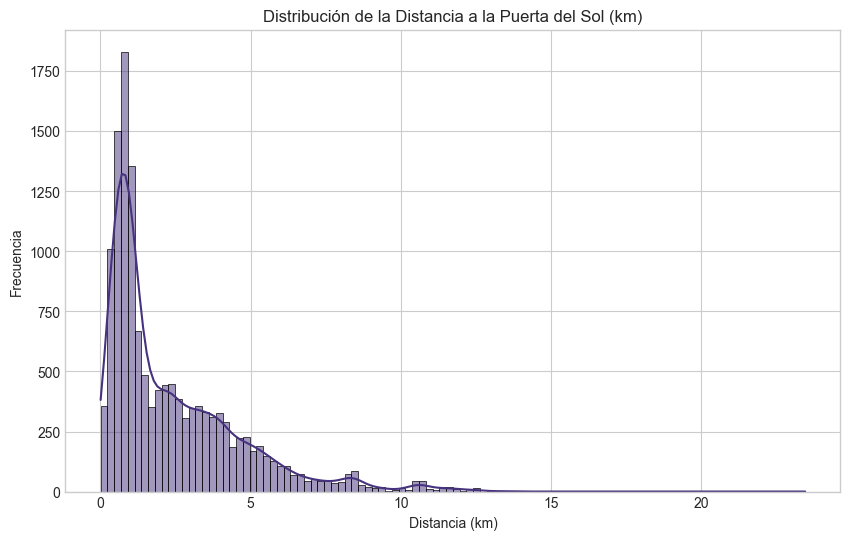

In [3]:
# 3.1 Distancia al Centro (Puerta del Sol)
# Coordenadas aproximadas de la Puerta del Sol, Madrid
sol_lat, sol_lon = 40.416775, -3.703790

# Función para calcular la distancia Haversine (distancia en esfera)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radio de la Tierra en km
    dLat = np.radians(lat2 - lat1)
    dLon = np.radians(lon2 - lon1)
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    a = np.sin(dLat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dLon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

df_selected["dist_sol_km"] = haversine(df_selected["latitude"], df_selected["longitude"], sol_lat, sol_lon)

print("Estadísticas descriptivas de la distancia a Sol:")
print(df_selected["dist_sol_km"].describe())

# Visualización de la nueva característica
plt.figure(figsize=(10, 6))
sns.histplot(df_selected["dist_sol_km"], kde=True)
plt.title("Distribución de la Distancia a la Puerta del Sol (km)")
plt.xlabel("Distancia (km)")
plt.ylabel("Frecuencia")
plt.show()

In [4]:
# 3.2 Agrupación de Tipos de Propiedad Poco Frecuentes
# Identificamos tipos de propiedad con pocas instancias
property_counts = df_selected["property_type"].value_counts()
threshold = 50 # Umbral para considerar una categoría como poco frecuente
rare_properties = property_counts[property_counts < threshold].index.tolist()

print(f"Número de tipos de propiedad antes de agrupar: {len(property_counts)}")
print(f"Número de tipos de propiedad poco frecuentes (menos de {threshold} instancias): {len(rare_properties)}")

# Agrupamos las categorías poco frecuentes en "Other"
df_selected["property_type_grouped"] = df_selected["property_type"].apply(lambda x: "Other" if x in rare_properties else x)

print(f"\nNúmero de tipos de propiedad después de agrupar: {df_selected['property_type_grouped'].nunique()}")
print("\nDistribución de los nuevos tipos de propiedad:")
print(df_selected["property_type_grouped"].value_counts())

Número de tipos de propiedad antes de agrupar: 21
Número de tipos de propiedad poco frecuentes (menos de 50 instancias): 16

Número de tipos de propiedad después de agrupar: 6

Distribución de los nuevos tipos de propiedad:
property_type_grouped
Entire rental unit           12392
Entire condo                   420
Entire loft                    395
Entire serviced apartment      275
Entire home                    247
Other                          142
Name: count, dtype: int64


## 4. Preprocesamiento de Datos Mejorado
Aplicamos el preprocesamiento, incluyendo el manejo de nulos, la codificación de variables categóricas (usando la nueva variable agrupada) y el escalado de numéricas (incluyendo la nueva variable de distancia).

In [5]:
# Manejo de valores faltantes (igual que antes)
print("Valores nulos antes de eliminar:")
print(df_selected.isnull().sum())
df_clean = df_selected.dropna(subset=["bathrooms", "bedrooms", "price"]) # Aseguramos eliminar nulos en columnas clave
print(f"\nFilas originales: {len(df_selected)}")
print(f"Filas después de eliminar valores nulos: {len(df_clean)}")
print(f"Filas eliminadas: {len(df_selected) - len(df_clean)}")

Valores nulos antes de eliminar:
neighbourhood_group_cleansed    0
latitude                        0
longitude                       0
property_type                   0
bathrooms                       0
bedrooms                        0
aire                            0
garaje                          0
calefaccion                     0
ascensor                        0
price                           0
dist_sol_km                     0
property_type_grouped           0
dtype: int64

Filas originales: 13871
Filas después de eliminar valores nulos: 13871
Filas eliminadas: 0


Filas después de eliminar valores nulos: 13871
Filas después de filtrar outliers extremos: 13369
Outliers eliminados: 502


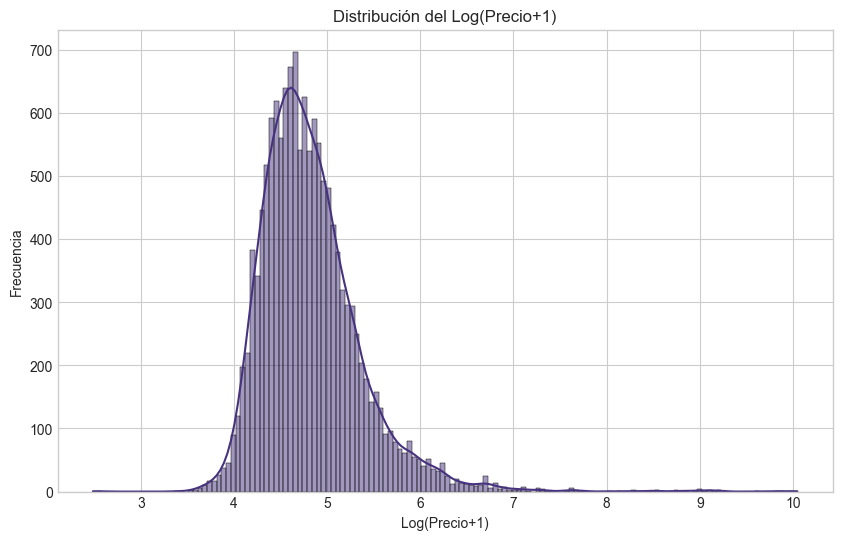

In [6]:
# Verificamos si hay valores extremos en el precio y los filtramos
# Utilizamos el rango intercuartílico para identificar outliers
Q1 = df_clean['price'].quantile(0.25)
Q3 = df_clean['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 3 * IQR  # Usamos 3 veces el IQR para ser menos restrictivos
upper_bound = Q3 + 3 * IQR

# Filtramos los outliers extremos
df_filtered = df_clean[(df_clean['price'] >= lower_bound) & (df_clean['price'] <= upper_bound)]
print(f"Filas después de eliminar valores nulos: {len(df_clean)}")
print(f"Filas después de filtrar outliers extremos: {len(df_filtered)}")
print(f"Outliers eliminados: {len(df_clean) - len(df_filtered)}")

# Aplicaremos log(price+1) para manejar la asimetría y reducir el impacto de outliers
df_clean["log_price"] = np.log1p(df_clean["price"])

# Visualización de la distribución del log(precio)
plt.figure(figsize=(10, 6))
sns.histplot(df_clean["log_price"], kde=True)
plt.title("Distribución del Log(Precio+1)")
plt.xlabel("Log(Precio+1)")
plt.ylabel("Frecuencia")
plt.show()

In [7]:
# Separamos las características (X) y la variable objetivo (y)
# Usaremos log_price como objetivo y eliminaremos las columnas originales de precio y tipo de propiedad
X = df_clean.drop(["price", "log_price", "property_type"], axis=1)
y = df_clean["log_price"]

In [8]:
# Identificamos las columnas categóricas y numéricas actualizadas
categorical_cols = ["neighbourhood_group_cleansed", "property_type_grouped"]
numerical_cols = ["latitude", "longitude", "bathrooms", "bedrooms", "aire", "garaje", "calefaccion", "ascensor", "dist_sol_km"]

In [9]:
# Verificamos que todas las columnas estén incluidas
print(f"Columnas categóricas: {categorical_cols}")
print(f"Columnas numéricas: {numerical_cols}")
print(f"Total de columnas en X: {X.shape[1]}")

Columnas categóricas: ['neighbourhood_group_cleansed', 'property_type_grouped']
Columnas numéricas: ['latitude', 'longitude', 'bathrooms', 'bedrooms', 'aire', 'garaje', 'calefaccion', 'ascensor', 'dist_sol_km']
Total de columnas en X: 11


In [10]:
# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

Tamaño del conjunto de entrenamiento: (11096, 11)
Tamaño del conjunto de prueba: (2775, 11)


In [11]:
# Creamos el preprocesador actualizado
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_cols),
        ("num", numerical_transformer, numerical_cols)
    ], remainder="passthrough") # Mantenemos otras columnas si las hubiera

In [12]:
# Aplicamos el preprocesador para verificar
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print(f"Dimensiones de X_train después del preprocesamiento: {X_train_processed.shape}")

Dimensiones de X_train después del preprocesamiento: (11096, 36)


## 5. Modelado y Evaluación (con Nuevas Métricas y Modelos)
Entrenamos y evaluamos los modelos anteriores y los nuevos (XGBoost, LightGBM), utilizando el conjunto completo de métricas, incluyendo EVS y MAPE. Trabajaremos con la variable objetivo transformada (log_price) y revertiremos la transformación para interpretar las métricas de error (RMSE, MAE, MAPE) en la escala original del precio.

In [13]:
# Función de evaluación actualizada
def evaluate_model_enhanced(model, X_train, X_test, y_train_log, y_test_log):
    # Entrenar el modelo con datos preprocesados
    model.fit(X_train, y_train_log)
    
    # Realizar predicciones en escala logarítmica
    y_pred_train_log = model.predict(X_train)
    y_pred_test_log = model.predict(X_test)
    
    # Revertir la transformación logarítmica para evaluación en escala original
    y_train_orig = np.expm1(y_train_log)
    y_test_orig = np.expm1(y_test_log)
    y_pred_train_orig = np.expm1(y_pred_train_log)
    y_pred_test_orig = np.expm1(y_pred_test_log)
    
    # Asegurarse de que las predicciones no sean negativas (puede ocurrir por errores numéricos)
    y_pred_train_orig = np.maximum(0, y_pred_train_orig)
    y_pred_test_orig = np.maximum(0, y_pred_test_orig)
    
    # Calcular métricas en escala original
    train_rmse = np.sqrt(mean_squared_error(y_train_orig, y_pred_train_orig))
    test_rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_test_orig))
    train_mae = mean_absolute_error(y_train_orig, y_pred_train_orig)
    test_mae = mean_absolute_error(y_test_orig, y_pred_test_orig)
    train_mape = mean_absolute_percentage_error(y_train_orig, y_pred_train_orig)
    test_mape = mean_absolute_percentage_error(y_test_orig, y_pred_test_orig)
    
    # Calcular métricas en escala logarítmica (R² y EVS se interpretan mejor en la escala del modelo)
    train_r2 = r2_score(y_train_log, y_pred_train_log)
    test_r2 = r2_score(y_test_log, y_pred_test_log)
    train_evs = explained_variance_score(y_train_log, y_pred_train_log)
    test_evs = explained_variance_score(y_test_log, y_pred_test_log)
    
    return {
        "train_rmse": train_rmse, "test_rmse": test_rmse,
        "train_mae": train_mae, "test_mae": test_mae,
        "train_mape": train_mape, "test_mape": test_mape,
        "train_r2": train_r2, "test_r2": test_r2,
        "train_evs": train_evs, "test_evs": test_evs
    }

In [14]:
# Definimos los modelos a probar (incluyendo los nuevos)
models_enhanced = {
    "Regresión Lineal": Pipeline(steps=[("preprocessor", preprocessor),
                                        ("regressor", LinearRegression())]),
    "Ridge": Pipeline(steps=[("preprocessor", preprocessor),
                            ("regressor", Ridge(alpha=1.0, random_state=42))]),
    "Lasso": Pipeline(steps=[("preprocessor", preprocessor),
                            ("regressor", Lasso(alpha=0.01, random_state=42))]), # Ajustar alpha si es necesario
    "Árbol de Decisión": Pipeline(steps=[("preprocessor", preprocessor),
                                        ("regressor", DecisionTreeRegressor(random_state=42))]),
    "Random Forest": Pipeline(steps=[("preprocessor", preprocessor),
                                    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))]),
    "Gradient Boosting": Pipeline(steps=[("preprocessor", preprocessor),
                                        ("regressor", GradientBoostingRegressor(n_estimators=100, random_state=42))]),
    "XGBoost": Pipeline(steps=[("preprocessor", preprocessor),
                             ("regressor", xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42, n_jobs=-1))]),
    "LightGBM": Pipeline(steps=[("preprocessor", preprocessor),
                              ("regressor", lgb.LGBMRegressor(objective="regression", n_estimators=100, random_state=42, n_jobs=-1))])
}

In [15]:
# Evaluamos cada modelo y guardamos los resultados
results_enhanced = {}

for name, model in models_enhanced.items():
    print(f"Evaluando {name}...")
    try:
        results_enhanced[name] = evaluate_model_enhanced(model, X_train, X_test, y_train, y_test)
        print(f"  RMSE (Test): {results_enhanced[name]['test_rmse']:.2f}")
        print(f"  MAE (Test): {results_enhanced[name]['test_mae']:.2f}")
        print(f"  MAPE (Test): {results_enhanced[name]['test_mape']:.2f}%")
        print(f"  R² (Test): {results_enhanced[name]['test_r2']:.4f}")
        print(f"  EVS (Test): {results_enhanced[name]['test_evs']:.4f}")
    except Exception as e:
        print(f"Error evaluando {name}: {e}")
        results_enhanced[name] = {k: np.nan for k in ["train_rmse", "test_rmse", "train_mae", "test_mae", "train_mape", "test_mape", "train_r2", "test_r2", "train_evs", "test_evs"]}
    print("")

Evaluando Regresión Lineal...
  RMSE (Test): 453.83
  MAE (Test): 62.84
  MAPE (Test): 29.08%
  R² (Test): 0.3489
  EVS (Test): 0.3496

Evaluando Ridge...
  RMSE (Test): 453.84
  MAE (Test): 62.84
  MAPE (Test): 29.08%
  R² (Test): 0.3489
  EVS (Test): 0.3496

Evaluando Lasso...
  RMSE (Test): 454.17
  MAE (Test): 63.88
  MAPE (Test): 29.77%
  R² (Test): 0.3277
  EVS (Test): 0.3283

Evaluando Árbol de Decisión...
  RMSE (Test): 500.79
  MAE (Test): 84.75
  MAPE (Test): 45.59%
  R² (Test): -0.0221
  EVS (Test): -0.0213

Evaluando Random Forest...
  RMSE (Test): 451.53
  MAE (Test): 61.90
  MAPE (Test): 29.05%
  R² (Test): 0.3662
  EVS (Test): 0.3669

Evaluando Gradient Boosting...
  RMSE (Test): 453.07
  MAE (Test): 61.78
  MAPE (Test): 28.25%
  R² (Test): 0.3789
  EVS (Test): 0.3796

Evaluando XGBoost...
  RMSE (Test): 452.73
  MAE (Test): 62.62
  MAPE (Test): 29.18%
  R² (Test): 0.3507
  EVS (Test): 0.3509

Evaluando LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading

In [16]:
# Creamos un DataFrame con los resultados para facilitar la comparación
results_list = []
for name, metrics in results_enhanced.items():
    metrics["Modelo"] = name
    results_list.append(metrics)

results_df_enhanced = pd.DataFrame(results_list)

# Reordenamos las columnas para mejor visualización
cols_order = ["Modelo", "test_rmse", "test_mae", "test_mape", "test_r2", "test_evs", 
              "train_rmse", "train_mae", "train_mape", "train_r2", "train_evs"]
results_df_enhanced = results_df_enhanced[cols_order]

# Ordenamos por RMSE en el conjunto de prueba (menor es mejor)
results_df_enhanced = results_df_enhanced.sort_values("test_rmse")

print("Tabla comparativa de modelos:")
results_df_enhanced

Tabla comparativa de modelos:


,Modelo,test_rmse,test_mae,test_mape,test_r2,test_evs,train_rmse,train_mae,train_mape,train_r2,train_evs
4,Random Forest,451.530579,61.904067,29.046478,0.366180,0.366865,405.649766,34.540625,10.458614,0.910665,0.910671
7,LightGBM,452.248845,61.387244,27.972545,0.391585,0.392038,493.322707,59.108501,24.656316,0.526586,0.526586
6,XGBoost,452.725941,62.620225,29.183746,0.350693,0.350862,401.564897,47.570082,20.290865,0.725170,0.725170
5,Gradient Boosting,453.065972,61.784971,28.247976,0.378936,0.379636,496.752962,62.197670,26.743885,0.439765,0.439765
0,Regresión Lineal,453.831436,62.839958,29.079154,0.348942,0.349603,500.023045,65.113604,28.451888,0.371981,0.371981
1,Ridge,453.835169,62.843273,29.077139,0.348915,0.349578,500.024129,65.115911,28.451523,0.371970,0.371970
2,Lasso,454.167756,63.877947,29.768447,0.327687,0.328315,500.335122,66.084484,29.189428,0.351577,0.351577
3,Árbol de Decisión,500.792163,84.746281,45.587121,-0.022148,-0.021281,4.962313,0.417345,0.284443,0.998276,0.998276


## 6. Explicación de Métricas y Selección del Modelo
A continuación, explicamos el significado de cada métrica utilizada y cómo nos ayudan a seleccionar el modelo más adecuado.

### Interpretación de Métricas
 
1.  **RMSE (Root Mean Squared Error - Error Cuadrático Medio Raíz)**:
     -   *Qué mide*: La desviación estándar de los residuos (errores de predicción). Penaliza más los errores grandes.
     -   *Unidad*: La misma que la variable objetivo (en este caso, euros, ya que evaluamos en la escala original).
     -   *Interpretación*: Un valor más bajo indica un mejor ajuste del modelo. Representa el error típico de predicción.
 
2.  **MAE (Mean Absolute Error - Error Absoluto Medio)**:
     -   *Qué mide*: El promedio de los errores absolutos (|real - predicción|).
     -   *Unidad*: La misma que la variable objetivo (euros).
     -   *Interpretación*: Un valor más bajo indica un mejor ajuste. Es menos sensible a outliers que el RMSE y representa el error promedio absoluto.
 
 3.  **MAPE (Mean Absolute Percentage Error - Error Porcentual Absoluto Medio)**:
     -   *Qué mide*: El error absoluto promedio como un porcentaje del valor real.
     -   *Unidad*: Porcentaje (%).
     -   *Interpretación*: Un valor más bajo indica un mejor ajuste. Es útil para comparar el rendimiento entre diferentes escalas o datasets. Un MAPE del 10% significa que, en promedio, la predicción difiere del valor real en un 10%. *Precaución*: Puede ser problemático si los valores reales son cercanos a cero.
 
 4.  **R² (R-squared - Coeficiente de Determinación)**:
     -   *Qué mide*: La proporción de la varianza en la variable dependiente que es predecible a partir de las variables independientes. Se calcula sobre la escala logarítmica en nuestro caso.
     -   *Rango*: Teóricamente de -∞ a 1. Un valor cercano a 1 indica que el modelo explica una gran parte de la variabilidad. Un valor de 0 indica que el modelo no es mejor que predecir simplemente la media. Valores negativos indican un modelo muy malo.
     -   *Interpretación*: Un valor más alto generalmente indica un mejor ajuste (en la escala logarítmica).
 
 5.  **EVS (Explained Variance Score - Puntuación de Varianza Explicada)**:
     -   *Qué mide*: Similar al R², mide la proporción de la varianza de la variable objetivo que el modelo logra explicar. Se calcula sobre la escala logarítmica.
     -   *Rango*: De -∞ a 1. Un valor de 1 indica una predicción perfecta.
     -   *Interpretación*: Un valor más alto indica un mejor ajuste. Es útil porque compara la varianza del error de predicción con la varianza de los valores reales.
 
### Criterios de Selección

La elección del "mejor" modelo depende de los objetivos:

-   **Si la prioridad es la precisión general (minimizar el error típico):** Nos fijamos principalmente en el **RMSE** y **MAE** (valores más bajos son mejores). El **MAPE** da una idea del error relativo.
-   **Si la prioridad es explicar la variabilidad de los precios:** Nos fijamos en **R²** y **EVS** (valores más altos son mejores, cercanos a 1).
-   **Si la prioridad es un modelo robusto y generalizable:** Comparamos las métricas entre los conjuntos de *entrenamiento* y *prueba*. Una diferencia grande indica sobreajuste (el modelo memoriza los datos de entrenamiento pero no generaliza bien a datos nuevos). Buscamos modelos donde las métricas de prueba sean cercanas a las de entrenamiento.
-   **Si la prioridad es la interpretabilidad:** Modelos como Regresión Lineal, Ridge, Lasso o Árboles de Decisión (con profundidad limitada) son más fáciles de interpretar que los ensembles complejos como Random Forest, Gradient Boosting, XGBoost o LightGBM.
-   **Consideraciones prácticas:** El tiempo de entrenamiento y predicción también puede ser un factor, especialmente con grandes datasets.

En nuestro caso, buscamos un buen equilibrio. Observando la tabla `results_df_enhanced`, podemos identificar los modelos con los menores errores (RMSE, MAE, MAPE) y los mayores R²/EVS en el conjunto de prueba, sin una diferencia excesiva respecto al conjunto de entrenamiento.

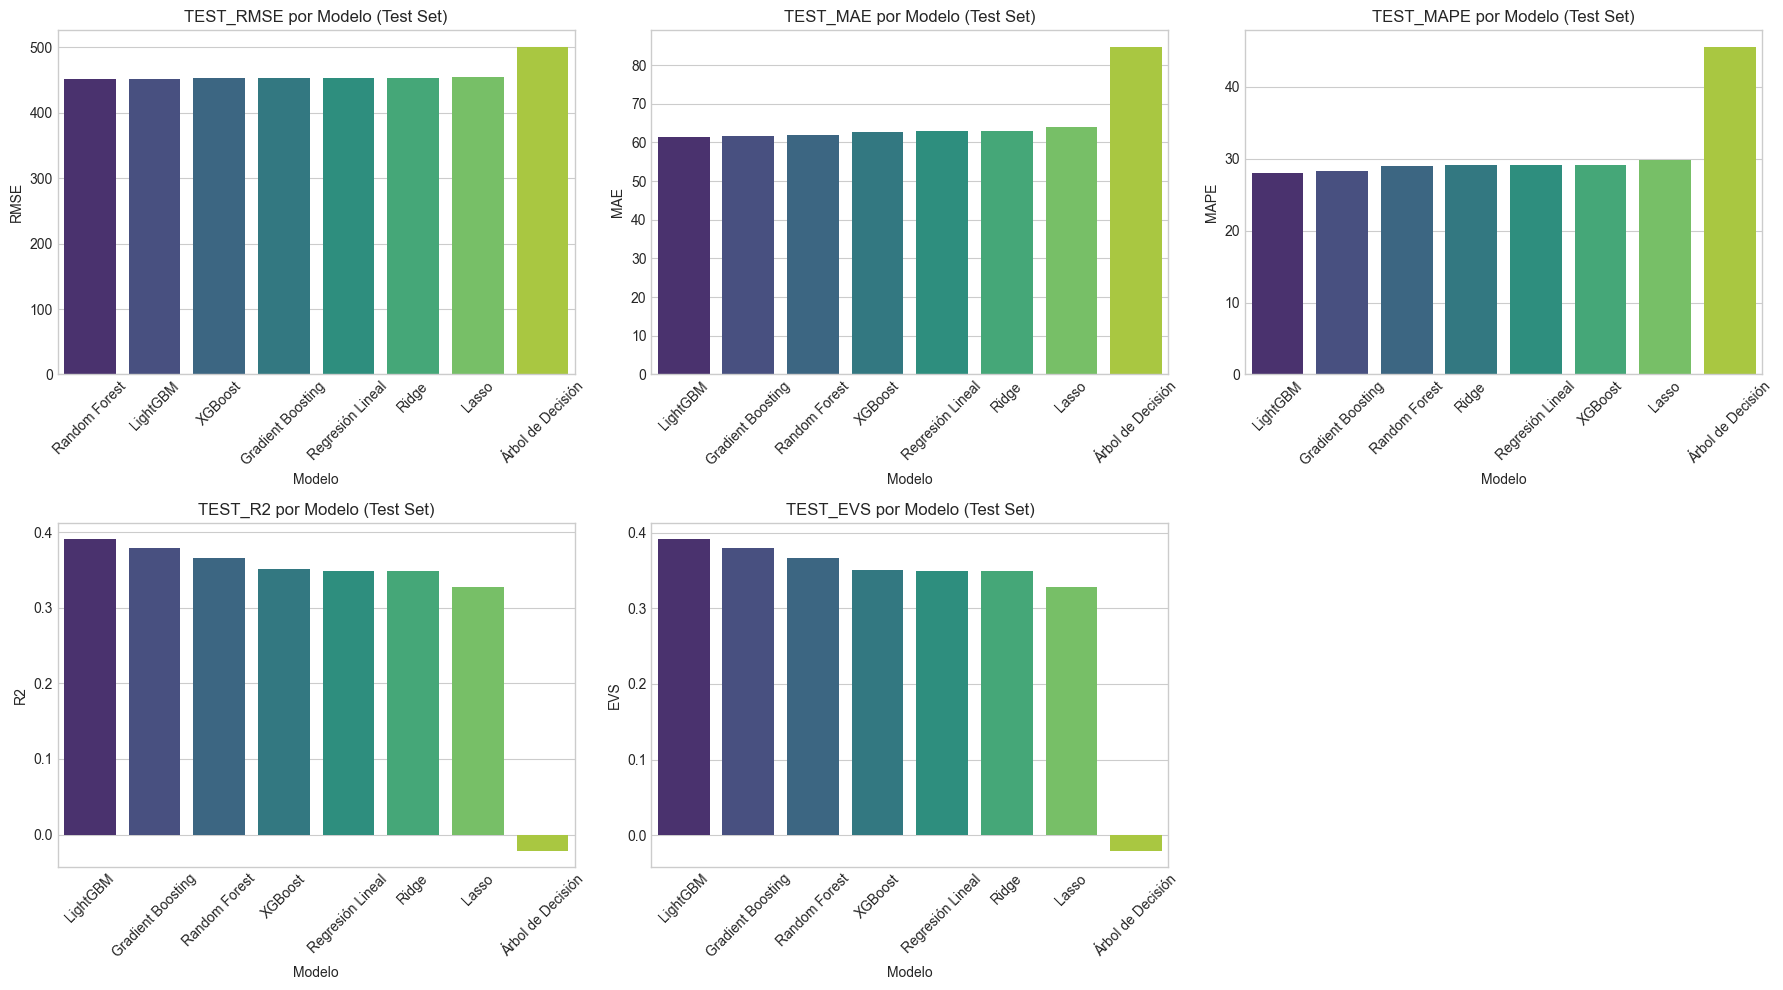

In [17]:
# Visualización comparativa de métricas clave (Test set)
metrics_to_plot = ["test_rmse", "test_mae", "test_mape", "test_r2", "test_evs"]
n_metrics = len(metrics_to_plot)
n_cols = 3
n_rows = (n_metrics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    # Ordenar por la métrica actual para la visualización
    sort_ascending = not (metric in ["test_r2", "test_evs"]) # RMSE, MAE, MAPE son mejores cuanto más bajos
    df_sorted = results_df_enhanced.sort_values(metric, ascending=sort_ascending)
    
    sns.barplot(x="Modelo", y=metric, data=df_sorted, ax=axes[i], palette="viridis")
    axes[i].set_title(f"{metric.upper()} por Modelo (Test Set)")
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].set_xlabel("Modelo")
    axes[i].set_ylabel(metric.split("_")[-1].upper())

# Ocultar ejes sobrantes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 7. Optimización del Mejor Modelo (Opcional)
Basándonos en las métricas, seleccionamos el modelo con mejor rendimiento general y realizamos una búsqueda de hiperparámetros para intentar mejorarlo aún más.

In [18]:
# Seleccionar el mejor modelo (ej: basado en menor RMSE en test)
best_model_name = results_df_enhanced.iloc[0]["Modelo"]
print(f"El mejor modelo inicial es: {best_model_name}")

# Creamos el pipeline con el preprocesador y el modelo Random Forest
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Definir el pipeline y la rejilla de parámetros para el mejor modelo
param_grid = {
    "regressor__n_estimators": [100, 200, 500],
     "regressor__max_depth": [None, 10, 20],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__min_samples_leaf": [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2', None],  
    'regressor__bootstrap': [True, False]
    }
base_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Configuramos GridSearchCV con validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_root_mean_squared_error',  # Optimizamos para minimizar RMSE
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=2   # Mostrar progreso detallado
)
# Realizar GridSearchCV si hay parámetros definidos
print (f"\nRealizando búsqueda de hiperparámetros para {best_model_name}...")
pipeline_to_tune = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", base_model)])
    
# Usamos neg_root_mean_squared_error para optimizar RMSE directamente
# Nota: Trabajamos sobre y_train (log_price)
grid_search = GridSearchCV(pipeline_to_tune, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42), 
                             scoring="neg_root_mean_squared_error", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
    
print(f"Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Evaluar el modelo optimizado
optimized_model = grid_search.best_estimator_
print("\nEvaluando modelo optimizado:")
optimized_results = evaluate_model_enhanced(optimized_model, X_train, X_test, y_train, y_test)
    
print(f"  RMSE (Test): {optimized_results['test_rmse']:.2f}")
print(f"  MAE (Test): {optimized_results['test_mae']:.2f}")
print(f"  MAPE (Test): {optimized_results['test_mape']:.2f}%")
print(f"  R² (Test): {optimized_results['test_r2']:.4f}")
print(f"  EVS (Test): {optimized_results['test_evs']:.4f}")

El mejor modelo inicial es: Random Forest

Realizando búsqueda de hiperparámetros para Random Forest...
Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Mejores parámetros encontrados:
{'regressor__bootstrap': True, 'regressor__max_depth': 20, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 500}

Evaluando modelo optimizado:
  RMSE (Test): 452.11
  MAE (Test): 60.69
  MAPE (Test): 27.58%
  R² (Test): 0.4042
  EVS (Test): 0.4048


In [19]:
# Entrenamos el modelo optimizado con todo el conjunto de entrenamiento
optimized_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['neighbourhood_group_cleansed',
                                                   'property_type_grouped']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['latitude', 'longitude',
                                                   'bathrooms', 'bedrooms',
                                                   'aire', 'garaje',
                                                   'calefaccion', 'ascensor',
                                                   'dist_sol_km'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=20, max_features='sqrt',
                                       min_samples_leaf=2, n_estimators=500,
                                       n_jobs=-1, random_state=42))])

## 8. Análisis de Importancia de Características (Modelo Final)
Analizamos qué características son más influyentes en las predicciones del modelo final optimizado (si es un modelo basado en árboles).

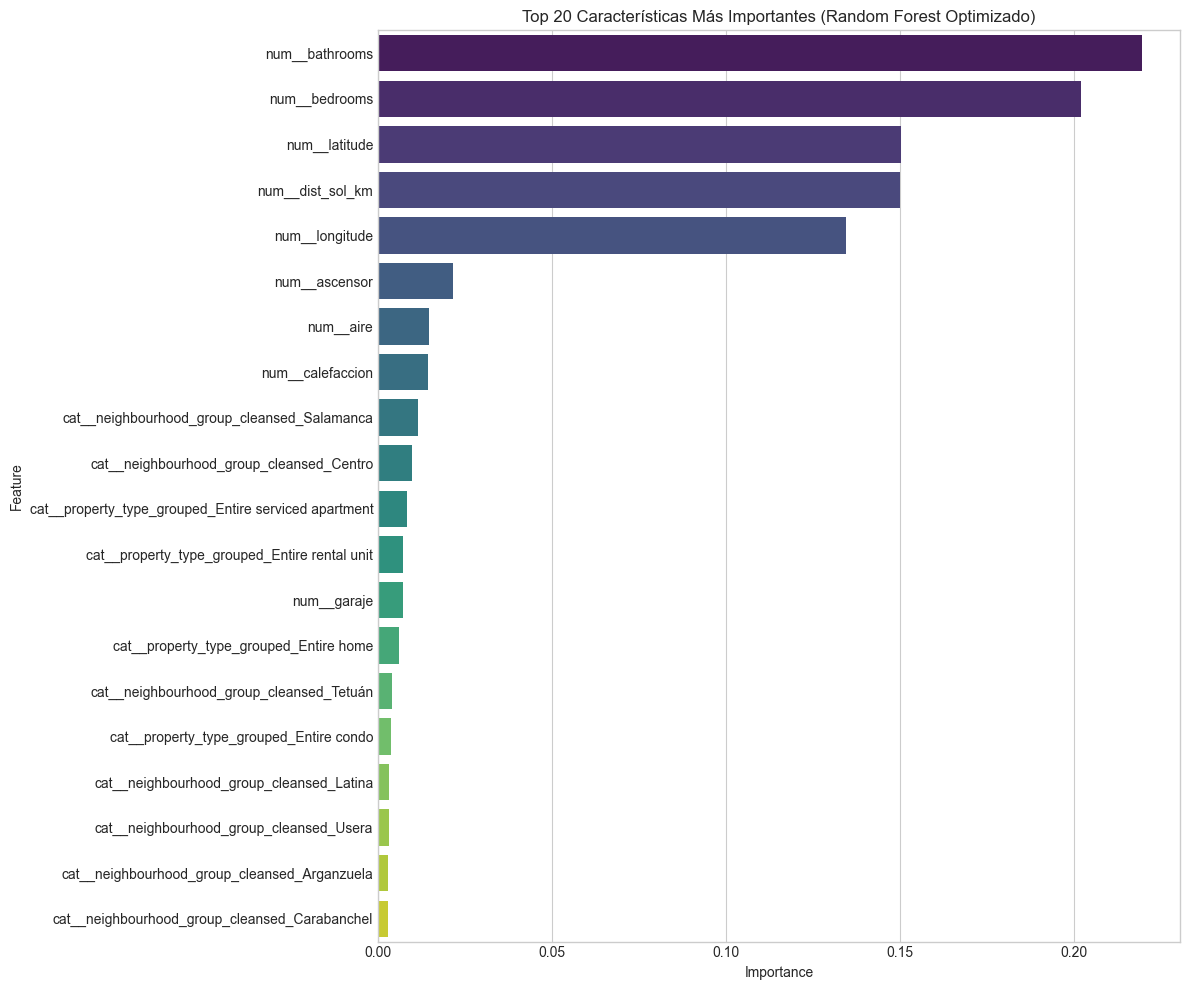


Top 20 Características:
                                              Feature  Importance
29                                     num__bathrooms    0.219454
30                                      num__bedrooms    0.201956
27                                      num__latitude    0.150182
35                                   num__dist_sol_km    0.150049
28                                     num__longitude    0.134353
34                                      num__ascensor    0.021520
31                                          num__aire    0.014725
33                                   num__calefaccion    0.014449
14        cat__neighbourhood_group_cleansed_Salamanca    0.011438
3            cat__neighbourhood_group_cleansed_Centro    0.009791
25  cat__property_type_grouped_Entire serviced apa...    0.008276
24      cat__property_type_grouped_Entire rental unit    0.007255
32                                        num__garaje    0.007064
22             cat__property_type_grouped_Entire ho

In [20]:
# Intentar obtener la importancia de características del modelo final
try:
    # Acceder al estimador dentro del pipeline
    final_regressor = optimized_model.named_steps["regressor"]
    
    if hasattr(final_regressor, "feature_importances_"):
        # Obtener nombres de características del preprocesador
        preprocessor_fitted = optimized_model.named_steps["preprocessor"]
        cat_features_names = preprocessor_fitted.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(categorical_cols)
        num_features_names = numerical_cols
        
        # Combinar nombres de características
        if hasattr(preprocessor_fitted, "get_feature_names_out"):
             # Para versiones más nuevas de scikit-learn
             feature_names = preprocessor_fitted.get_feature_names_out()
        else:
             # Fallback para versiones anteriores (puede requerir ajuste)
             feature_names = list(cat_features_names) + list(num_features_names)

        importances = final_regressor.feature_importances_
        
        # Crear DataFrame de importancia
        importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
        importance_df = importance_df.sort_values("Importance", ascending=False)
        
        # Visualizar las top 20 características
        plt.figure(figsize=(12, 10))
        sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="viridis")
        plt.title(f"Top 20 Características Más Importantes ({best_model_name} Optimizado)")
        plt.tight_layout()
        plt.show()
        
        print("\nTop 20 Características:")
        print(importance_df.head(20))
        
    else:
        print(f"El modelo {best_model_name} no tiene el atributo 'feature_importances_'.")

except Exception as e:
    print(f"No se pudo obtener la importancia de características: {e}")

## 9. Visualización de Predicciones (Modelo Final)
Visualizamos las predicciones del modelo final en comparación con los valores reales, tanto en escala logarítmica como original.

In [21]:
# Realizar predicciones con el modelo final optimizado
y_pred_train_log_final = optimized_model.predict(X_train)
y_pred_test_log_final = optimized_model.predict(X_test)

# Revertir a escala original
y_train_orig = np.expm1(y_train)
y_test_orig = np.expm1(y_test)
y_pred_train_orig_final = np.expm1(y_pred_train_log_final)
y_pred_test_orig_final = np.expm1(y_pred_test_log_final)

# Asegurar no negativos
y_pred_train_orig_final = np.maximum(0, y_pred_train_orig_final)
y_pred_test_orig_final = np.maximum(0, y_pred_test_orig_final)

# Crear DataFrame para visualización (Test set)
pred_df_final = pd.DataFrame({
    "Real_Log": y_test,
    "Predicho_Log": y_pred_test_log_final,
    "Real_Original": y_test_orig,
    "Predicho_Original": y_pred_test_orig_final
})
pred_df_final["Residuo_Log"] = pred_df_final["Real_Log"] - pred_df_final["Predicho_Log"]
pred_df_final["Residuo_Original"] = pred_df_final["Real_Original"] - pred_df_final["Predicho_Original"]

In [22]:
# Tabla de precio real vs precio predicho
print("Tabla de comparación entre Precio Real y Precio Predicho:")
pred_df_final.head(10)

Tabla de comparación entre Precio Real y Precio Predicho:


,Real_Log,Predicho_Log,Real_Original,Predicho_Original,Residuo_Log,Residuo_Original
5040,5.003946,5.224169,148.0,184.706731,-0.220222,-36.706731
1078,5.673323,5.340056,290.0,207.524353,0.333267,82.475647
13717,4.644391,4.469112,103.0,86.279187,0.175279,16.720813
3527,4.644391,4.599580,103.0,98.442534,0.044811,4.557466
3404,5.463832,5.244801,235.0,188.578104,0.219031,46.421896
360,4.521789,4.638799,91.0,102.420064,-0.117010,-11.420064
977,4.369448,4.558093,78.0,94.401357,-0.188645,-16.401357
1650,4.543295,4.714479,93.0,110.550651,-0.171184,-17.550651
8862,4.158883,4.686309,63.0,107.452118,-0.527426,-44.452118
6182,6.401917,5.982328,602.0,395.361936,0.419589,206.638064
